In [30]:
import numpy as np
import urllib
import matplotlib.pyplot as plt

R_i = np.array(
    [
        -0.5630,
        0.5160,
        0.0071,
        0.5630,
        -0.5159,
        0.0071,
        -1.9293,
        -0.1506,
        -0.0071,
        1.9294,
        0.1505,
        -0.0071,
        -0.4724,
        1.1666,
        -0.8706,
        -0.4825,
        1.1551,
        0.8940,
        0.4825,
        -1.1551,
        0.8940,
        0.4723,
        -1.1665,
        -0.8706,
        -2.0542,
        -0.7710,
        -0.9003,
        -2.0651,
        -0.7856,
        0.8742,
        -2.7203,
        0.6060,
        -0.0058,
        2.0542,
        0.7709,
        -0.9003,
        2.7202,
        -0.6062,
        -0.0059,
        2.0652,
        0.7854,
        0.8743,
    ]
).reshape(-1, 3)
N = R_i.shape[0]
X_i = np.zeros((N, 2))
X_i[:4, 0] = 1
X_i[4:, 1] = 1

In [31]:
# our 1-hidden layer model
def hidden_model(r, x, w1, w2, b1, b2):
    # stack into one large input
    i = np.concatenate((r, x), axis=1).flatten()
    print(i.shape)
    v = np.tanh(i @ w1 + b1)
    print(v.shape)
    v = v @ w2 + b2
    return v


# initialize our weights
w1 = np.random.normal(size=(N * 5, 16))  # 5 -> 3 xyz + 2 features
b1 = np.random.normal(size=(16,))
w2 = np.random.normal(size=(16,))
b2 = np.random.normal()

In [8]:
import scipy.spatial.transform as trans

# rotate around x coord by 45 degrees
rot = trans.Rotation.from_euler("x", 45, degrees=True)

print("No rotation", hidden_model(R_i, X_i, w1, w2, b1, b2))
print("Rotated", hidden_model(rot.apply(R_i), X_i, w1, w2, b1, b2))

No rotation -1.317272925011784
Rotated -1.4423541242997344


In [9]:
# swap 0, 1 rows
perm_R_i = np.copy(R_i)
perm_R_i[0], perm_R_i[1] = R_i[1], R_i[0]
# we do not need to swap X_i 0,1 because they are identical

print("original", hidden_model(R_i, X_i, w1, w2, b1, b2))
print("permuted", hidden_model(perm_R_i, X_i, w1, w2, b1, b2))

original -1.317272925011784
permuted -0.7393586208677944


In [34]:
# our 1-hidden layer model with perm inv
def hidden_model_pi(r, x, w1, w2, b1, b2):
    # stack into one large input
    print(r.shape)
    i = np.concatenate((r, x), axis=1)
    print(i.shape)
    v = np.tanh(i @ w1 + b1)
    # reduction
    print(v.shape)
    v = np.sum(v, axis=0)
    print(v.shape)
    v = v @ w2 + b2
    return v


# initialize our weights
w1 = np.random.normal(size=(5, 16))  # note it no lonegr has N!
b1 = np.random.normal(size=(16,))
w2 = np.random.normal(size=(16,))
b2 = np.random.normal()

In [35]:
print("original", hidden_model_pi(R_i, X_i, w1, w2, b1, b2))
print("permuted", hidden_model_pi(perm_R_i, X_i, w1, w2, b1, b2))

(14, 3)
(14, 5)
(14, 16)
(16,)
original 34.736983578472724
(14, 3)
(14, 5)
(14, 16)
(16,)
permuted 34.736983578472724


In [41]:
# our 1-hidden layer model with perm inv, trans inv
def hidden_model_pti(r, x, w1, w2, b1, b2):
    # compute pairwise distances using broadcasting
    d = r - r[:, np.newaxis]
    # stack into one large input of N x N x 5
    # concatenate doesn't broadcast, so I manually broadcast the Nx2 x matrix
    # into N x N x 2
    print(d.shape)
    i = np.concatenate((d, np.broadcast_to(x, (d.shape[:-1] + x.shape[-1:]))), axis=-1)
    print(i.shape)
    v = np.tanh(i @ w1 + b1)
    # reduction over both axes
    v = np.sum(v, axis=(0, 1))
    v = v @ w2 + b2
    return v

In [42]:
print("original", hidden_model_pti(R_i, X_i, w1, w2, b1, b2))
print("permuted", hidden_model_pti(perm_R_i, X_i, w1, w2, b1, b2))
print("translated", hidden_model_pti(R_i + np.array([-2, 3, 4]), X_i, w1, w2, b1, b2))
print("rotated", hidden_model_pti(rot.apply(R_i), X_i, w1, w2, b1, b2))

(14, 14, 3)
(14, 14, 5)
original 428.54997224550806
(14, 14, 3)
(14, 14, 5)
permuted 428.54997224550806
(14, 14, 3)
(14, 14, 5)
translated 428.54997224550806
(14, 14, 3)
(14, 14, 5)
rotated 433.63904306470926


In [50]:
# our 1-hidden layer model with perm, trans, rot inv.
def hidden_model_ptri(r, x, w1, w2, b1, b2):
    # compute pairwise distances using broadcasting
    d = r - r[:, np.newaxis]
    # x^2 + y^2 + z^2 of pairwise vectors
    # keepdims so we get an N x N x 1 output
    d2 = np.sum(d**2, axis=-1, keepdims=True)
    # stack into one large input of N x N x 3
    # concatenate doesn't broadcast, so I manually broadcast the Nx2 x matrix
    # into N x N x 2
    i = np.concatenate(
        (d2, np.broadcast_to(x, (d2.shape[:-1] + x.shape[-1:]))), axis=-1
    )
    v = np.tanh(i @ w1 + b1)
    # reduction over both axes
    v = np.sum(v, axis=(0, 1))
    v = v @ w2 + b2
    return v


# initialize our weights
w1 = np.random.normal(size=(3, 16))  # now just 1 dist feature
b1 = np.random.normal(size=(16,))
w2 = np.random.normal(size=(16,))
b2 = np.random.normal()

# test it

print("original", hidden_model_ptri(R_i, X_i, w1, w2, b1, b2))
print("permuted", hidden_model_ptri(perm_R_i, X_i, w1, w2, b1, b2))
print("translated", hidden_model_ptri(R_i + np.array([-2, 3, 4]), X_i, w1, w2, b1, b2))
print("rotated", hidden_model_ptri(rot.apply(R_i), X_i, w1, w2, b1, b2))

original -715.937555525552
permuted -715.937555525552
translated -715.937555525552
rotated -715.937555525552


In [51]:
R_i[0] = 2.0
print("changed", hidden_model_ptri(R_i, X_i, w1, w2, b1, b2))

changed -766.1067890207403


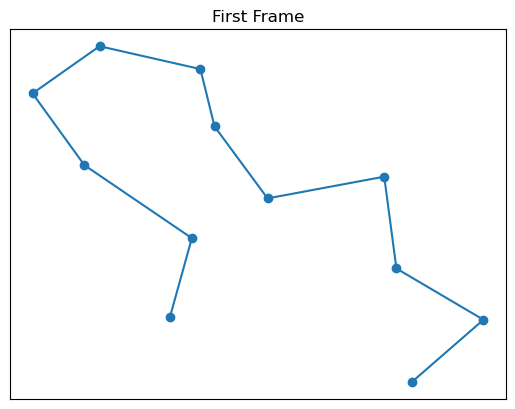

In [56]:
urllib.request.urlretrieve(
    "https://github.com/whitead/dmol-book/raw/main/data/paths.npz", "paths.npz"
)
paths = np.load("paths.npz")["arr"]
# plot the first point
plt.title("First Frame")
plt.plot(paths[0, :, 0], paths[0, :, 1], "o-")
plt.xticks([])
plt.yticks([])
plt.show()

In [60]:
def center_com(paths):
    """Align paths to COM at each frame"""
    coms = np.mean(paths, axis=-2, keepdims=True)
    return paths - coms


def center_point(paths):
    """Align paths to particle 0"""
    return paths - paths[:, :1]


ccpaths = center_com(paths)
cppaths = center_point(paths)

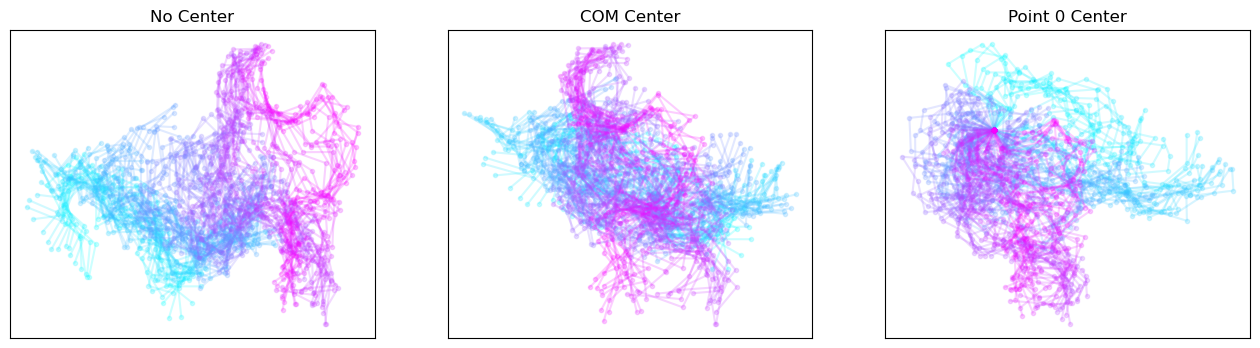

In [61]:
fig, axs = plt.subplots(ncols=3, squeeze=True, figsize=(16, 4))

axs[0].set_title("No Center")
axs[1].set_title("COM Center")
axs[2].set_title("Point 0 Center")
cmap = plt.get_cmap("cool")
for i in range(0, 2048, 16):
    axs[0].plot(paths[i, :, 0], paths[i, :, 1], ".-", alpha=0.2, color=cmap(i / 2048))
    axs[1].plot(
        ccpaths[i, :, 0], ccpaths[i, :, 1], ".-", alpha=0.2, color=cmap(i / 2048)
    )
    axs[2].plot(
        cppaths[i, :, 0], cppaths[i, :, 1], ".-", alpha=0.2, color=cmap(i / 2048)
    )
for i in range(3):
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [62]:
def make_2drot(angle):
    mats = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    # swap so batch axis is first
    return np.swapaxes(mats, 0, -1)


def align_point(paths):
    """Align to 0-1 vector assuming 2D data"""
    vecs = paths[:, 0, :] - paths[:, 1, :]
    # find angle to rotate so these are pointed towards pos x
    cur_angle = np.arctan2(vecs[:, 1], vecs[:, 0])
    rot_angle = -cur_angle
    rot_mat = make_2drot(rot_angle)
    # to mat mult at each frame
    return paths @ rot_mat


def find_principle_axis(points, naxis=2):
    """Compute single principle axis for points"""
    inertia = points.T @ points
    evals, evecs = np.linalg.eig(inertia)
    order = np.argsort(evals)[::-1]
    # return largest vectors
    return evecs[:, order[:naxis]].T


def align_principle(paths, axis_finder=find_principle_axis):
    # someone should tell me how to vectorize this in numpy
    vecs = [axis_finder(p) for p in paths]
    vecs = np.array(vecs)
    # find angle to rotate so these are pointed towards pos x
    cur_angle = np.arctan2(vecs[:, 0, 1], vecs[:, 0, 0])
    cross = np.cross(vecs[:, 0], vecs[:, 1])
    rot_angle = -cur_angle - (cross < 0) * np.pi
    rot_mat = make_2drot(rot_angle)
    # rotate at each frame
    rpaths = paths @ rot_mat
    return rpaths


appaths = align_point(cppaths)
apapaths = align_principle(ccpaths)

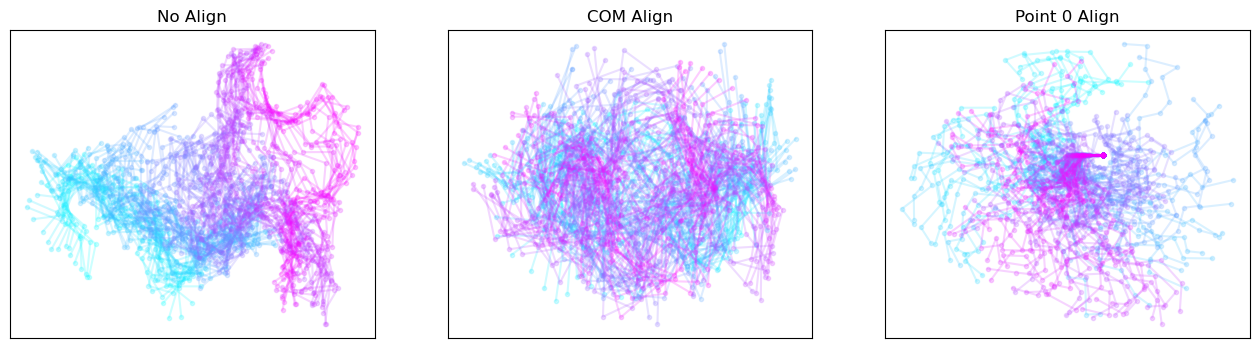

In [63]:
fig, axs = plt.subplots(ncols=3, squeeze=True, figsize=(16, 4))

axs[0].set_title("No Align")
axs[1].set_title("COM Align")
axs[2].set_title("Point 0 Align")
for i in range(0, 2048, 16):
    axs[0].plot(paths[i, :, 0], paths[i, :, 1], ".-", alpha=0.2, color=cmap(i / 2048))
    axs[1].plot(
        apapaths[i, :, 0], apapaths[i, :, 1], ".-", alpha=0.2, color=cmap(i / 2048)
    )
    axs[2].plot(
        appaths[i, :, 0], appaths[i, :, 1], ".-", alpha=0.2, color=cmap(i / 2048)
    )
for i in range(3):
    axs[i].set_xticks([])
    axs[i].set_yticks([])